In [241]:
import numpy as np
import pandas as pd

In [242]:
labels = pd.read_parquet('../case_power_forecasting/case_power_forecasting/data/labels.parquet', engine='pyarrow')
weather = pd.read_parquet('../case_power_forecasting/case_power_forecasting/data/weather_forecast.parquet', engine='pyarrow')

In [243]:
labels_index = pd.date_range(start=labels.index.min(), end=labels.index.max(), freq='15min')
labels.index = labels_index

In [244]:
# Add features based on dates -> part of day & Month -> simulate temperature  

conditions = [(0 <= labels.index.hour) & (labels.index.hour < 6), 
            (6 <= labels.index.hour) & (labels.index.hour < 12), 
            (12 <= labels.index.hour) & (labels.index.hour < 18), 
            (18 <= labels.index.hour) & (labels.index.hour < 24)]
choices = [0, 1, 2, 3]
labels['Day_part'] = np.select(condlist=conditions, choicelist=choices, default=np.nan)
labels['Month'] = labels.index.month
labels = labels[['Day_part', 'Month', 'power']]

In [245]:
labels.head()

,Day_part,Month,power
2019-01-01 00:00:00,0.0,1,48637.0
2019-01-01 00:15:00,0.0,1,52357.0
2019-01-01 00:30:00,0.0,1,54317.0
2019-01-01 00:45:00,0.0,1,54220.5
2019-01-01 01:00:00,0.0,1,51680.0


<AxesSubplot:title={'center':'Power'}>

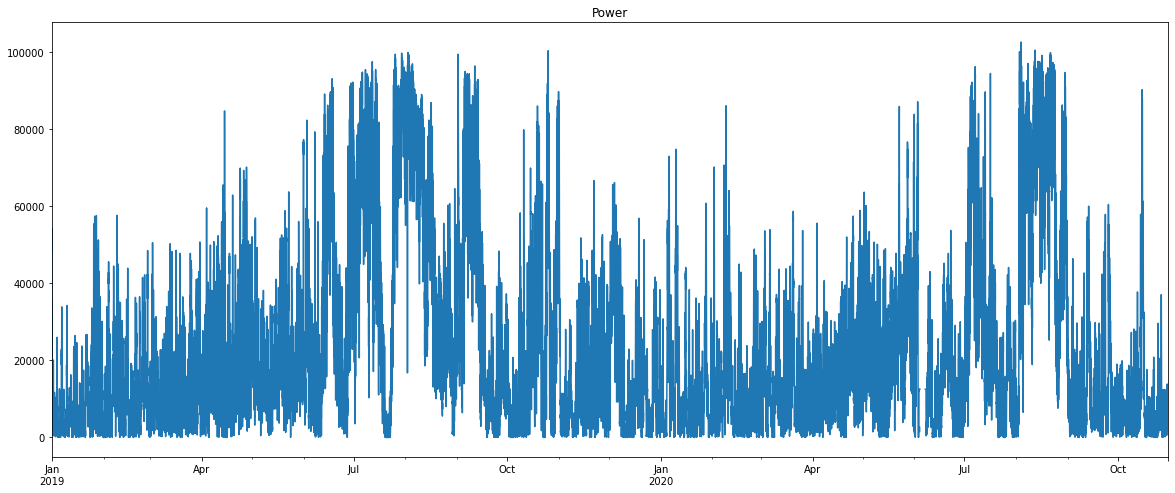

In [246]:
# Visualize the labels
labels['power'].plot(figsize=(20,8), title="Power")

In [247]:
weather.head()

,Generation_Date,Forecast_Date,U,V,ws,Direction
1,2019-06-25,2019-06-25 01:00:00,1.861707,0.195582,1.871952,264.002783
2,2019-06-25,2019-06-25 02:00:00,1.257695,0.570511,1.381043,245.600179
3,2019-06-25,2019-06-25 03:00:00,1.883554,0.701067,2.009794,249.584514
4,2019-06-25,2019-06-25 04:00:00,2.664914,0.169917,2.670325,266.351713
5,2019-06-25,2019-06-25 05:00:00,2.855113,-0.255226,2.866498,275.108242


In [248]:
weather = weather.drop('Generation_Date', axis=1).set_index('Forecast_Date')

In [249]:
weather.head()

,U,V,ws,Direction
Forecast_Date,,,,
2019-06-25 01:00:00,1.861707,0.195582,1.871952,264.002783
2019-06-25 02:00:00,1.257695,0.570511,1.381043,245.600179
2019-06-25 03:00:00,1.883554,0.701067,2.009794,249.584514
2019-06-25 04:00:00,2.664914,0.169917,2.670325,266.351713
2019-06-25 05:00:00,2.855113,-0.255226,2.866498,275.108242


In [250]:
# Merge the labels and weather data
data = pd.merge(left=labels, right=weather, left_index=True, right_index=True, how='left')

In [251]:
data.head()

,Day_part,Month,power,U,V,ws,Direction
2019-01-01 00:00:00,0.0,1,48637.0,NaN,NaN,NaN,NaN
2019-01-01 00:15:00,0.0,1,52357.0,NaN,NaN,NaN,NaN
2019-01-01 00:30:00,0.0,1,54317.0,NaN,NaN,NaN,NaN
2019-01-01 00:45:00,0.0,1,54220.5,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,0.0,1,51680.0,NaN,NaN,NaN,NaN


In [252]:
# Keep values from the start date of weather 
data = data[np.where(data.index == weather.index.min())[0][0]:]

In [253]:
data.head()

,Day_part,Month,power,U,V,ws,Direction
2019-06-25 01:00:00,0.0,6,4686.2,1.861707,0.195582,1.871952,264.002783
2019-06-25 01:15:00,0.0,6,4047.9,NaN,NaN,NaN,NaN
2019-06-25 01:30:00,0.0,6,3251.0,NaN,NaN,NaN,NaN
2019-06-25 01:45:00,0.0,6,2244.5,NaN,NaN,NaN,NaN
2019-06-25 02:00:00,0.0,6,2224.6,1.257695,0.570511,1.381043,245.600179


In [254]:
# Fill the hourly values forward to quarter hour 
data['U'] = data['U'].fillna(method='ffill')
data['V'] = data['V'].fillna(method='ffill')
data['ws'] = data['ws'].fillna(method='ffill')
data['Direction'] = data['Direction'].fillna(method='ffill')

In [255]:
# Rearrange so that power is the last column
data = data[['Day_part', 'Month', 'U', 'V', 'ws', 'Direction', 'power']]

In [256]:
data.head()

,Day_part,Month,U,V,ws,Direction,power
2019-06-25 01:00:00,0.0,6,1.861707,0.195582,1.871952,264.002783,4686.2
2019-06-25 01:15:00,0.0,6,1.861707,0.195582,1.871952,264.002783,4047.9
2019-06-25 01:30:00,0.0,6,1.861707,0.195582,1.871952,264.002783,3251.0
2019-06-25 01:45:00,0.0,6,1.861707,0.195582,1.871952,264.002783,2244.5
2019-06-25 02:00:00,0.0,6,1.257695,0.570511,1.381043,245.600179,2224.6


### Use Random Forest to impute missing power values

In [257]:
# Check for missing values
data.isna().sum()

Day_part       0
Month          0
U              0
V              0
ws             0
Direction      0
power        341
dtype: int64

In [258]:
rf_data = data[data['power'].notnull()] # Data with no missing values -> use this to train model
rf_data_inputs = rf_data.drop(['power'], axis=1)
rf_data_labels = rf_data['power']

In [259]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [260]:
X_train, X_test, y_train, y_test = train_test_split(rf_data_inputs, rf_data_labels, test_size=0.20)

In [261]:
rf_model = RandomForestRegressor(n_estimators=50)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.9687803530330317

In [262]:
# Get the values that are missing
pred_data = data[data['power'].isnull()].drop(['power'], axis=1)

In [263]:
predictions = rf_model.predict(pred_data)

In [264]:
# Replace the missing data with the predicted values
col = data.columns.get_loc('power')
for row, val in zip(np.where(data['power'].isnull())[0], predictions):
    data.iloc[row,col] = val

In [265]:
data.isnull().sum()

Day_part     0
Month        0
U            0
V            0
ws           0
Direction    0
power        0
dtype: int64

### Model building

In [266]:
np.set_printoptions(suppress=True)

In [267]:
index_1Aug2020 = np.where(data.index == '2020-08-01 00:00:00')[0][0]

training_data = data[:index_1Aug2020] 
testing_data = data[index_1Aug2020:]

In [268]:
training_data = training_data.loc['2019-06-26 00:15:00':'2020-07-30 00:00:00'].values # Ensure that it is divisible by 96

In [269]:
X = np.array(np.split(training_data, training_data.shape[0]//96))
X.shape

(400, 96, 7)

In [270]:
y = np.array([i[:,-1] for i in X[1:]])
y.shape

(399, 96)

In [271]:
# Delete the last X array -> make X & y the same size
X = X[:-1]
X.shape

(399, 96, 7)

In [272]:
# Flatten X
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
X.shape 

(399, 672)

In [273]:
n_output = y.shape[1]

In [274]:
# Train test split
X_train = X[:320]
X_test = X[320:]
y_train = y[:320]
y_test = y[320:]

In [275]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler(feature_range=(0, 1))
sc_Y = MinMaxScaler(feature_range=(0, 1))

In [276]:
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_Y.fit_transform(y_train)
y_test = sc_Y.transform(y_test)

In [277]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_output))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

In [ ]:
# Make predictions on X_test
testPredict = model.predict(X_test)

In [280]:
# Inverse the scaler
testPredict = sc_Y.inverse_transform(testPredict)

In [281]:
y_test = sc_Y.inverse_transform(y_test)

In [282]:
def norm_mean_abs_error(y_true, y_pred) -> float:
    return 100*((np.sum(np.abs(y_true - y_pred))/y_true.size)/106400)

In [283]:
norm_mean_abs_error(y_test, testPredict)

10.684729304324645

## Make predictions on the testing data

In [403]:
test_data = testing_data[1:].values
test_data_split = np.array(np.split(test_data , test_data.shape[0]//96))

In [404]:
test_data_split.shape

(91, 96, 7)

In [407]:
# Flatten test_data_split
n_input2 = test_data_split.shape[1] * test_data_split.shape[2]
test_data_flat = test_data_split.reshape((test_data_split.shape[0], n_input2))
test_data_flat.shape

(91, 672)

In [408]:
scaler_test = MinMaxScaler(feature_range=(0, 1))
test_data_scaled = sc_X.fit_transform(test_data_flat)

In [ ]:
yhat = model.predict(test_data_scaled)

In [411]:
yhat_invTrs = sc_Y.inverse_transform(yhat)
yhat_invTrs.shape

(91, 96)

In [417]:
yhat_flat = yhat_invTrs.flatten()

In [431]:
yhat_df = pd.DataFrame(yhat_flat,columns=['yhat'])
yhat_df.shape

(8736, 1)

In [436]:
y_yhat_df = pd.DataFrame(columns=['power'], index=testing_data.index)
y_yhat_df['power'] = testing_data['power'].values
y_yhat_df = y_yhat_df.iloc[1:]
y_yhat_df['yhat'] = yhat_df['yhat'].values

<AxesSubplot:title={'center':'Actual vs Predicted'}>

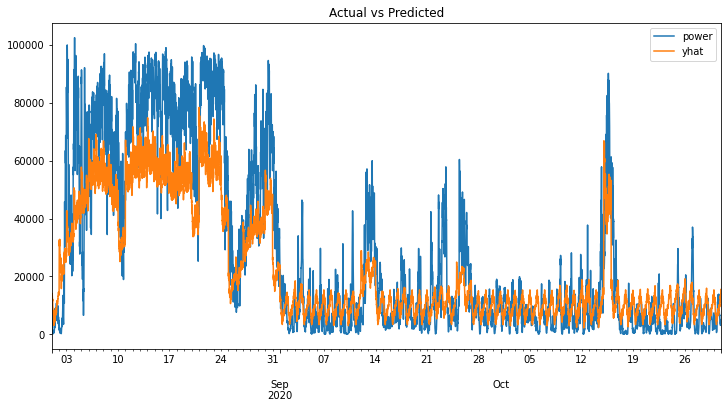

In [441]:
y_yhat_df.plot(figsize=(12,6), title='Actual vs Predicted')

In [442]:
norm_mean_abs_error(y_true=y_yhat_df['power'].values, y_pred=y_yhat_df['yhat'].values)

11.01228664821278

## Next steps

* Are months and parts of the day ordinal or categorical data?<br>
    * Approach for cyclic ordinal data: __[cyclic_ordinal_link](https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes)__  
* Hyper-parameter optimization: 
    * How to determine the number of layers, the neurons in the layers, drop-outs and activations. We can use a discrete optimization algorithm to try various combinations. The fitness function (accuracy, overfitting) will need to be defined and should be measurable.    
    * Optimize weights to reduce training time: Use this approach __[PSO_SGD_link](https://arxiv.org/pdf/2205.10456)__ : where SGD and PSO algorithm can be used together to yield better values
